In [156]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

outPlotDir = "./_maskedLanguageModelPlots"
os.makedirs(outPlotDir, exist_ok=True)


In [162]:
def plotLineScatterWithErr(valueTable, errorTable, title, xlabel, ylabel, ax=None, figsize=(10, 8)):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    for key in valueTable:
        ax.errorbar(valueTable[key].index, valueTable[key], yerr=errorTable[key], marker="o", label=key, capsize=5)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid()
    ax.legend()

def trainingDumpFolder(folder, pattern = "Losses.npy"):
    lossFiles = [file for file in os.listdir(folder) if file.endswith(pattern)]
    losses = np.vstack([np.load(os.path.join(folder, losses)) for losses in lossFiles])
    lossesMean = np.mean(losses, axis=0)
    lossesStd = np.std(losses, axis=0)
    return lossesMean, lossesStd

def plotLossesErrorShade(mean, std, ax=None, figsize=(10, 8)):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    ax.plot(mean, label="mean")
    ax.fill_between(np.arange(len(mean)), mean-std, mean+std, alpha=0.5, label="std")

def plotErrorShadeStats(folders, pattern = "Losses.npy", ax = None, figsize=(10, 8), xlim = None):
    meanPretrained, stdPretrained = trainingDumpFolder(folders[0], pattern)
    meanNonPretrained, stdNonPretrained = trainingDumpFolder(folders[1], pattern)
    meanFull, stdFull = trainingDumpFolder(folders[2], pattern)
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(13, 6))
    plotLossesErrorShade(meanPretrained, stdPretrained, ax=ax)
    plotLossesErrorShade(meanNonPretrained, stdNonPretrained, ax=ax)
    #plotLossesErrorShade(meanFull, stdFull, ax=ax)
    ax.set_xlabel("Batches")
    ax.set_ylabel("Loss")
    ax.grid()
    ax.legend([ax.get_lines()[0], ax.get_lines()[1]], ["Pretrained", "NonPretrained"])
    if xlim:
        ax.set_xlim(xlim)

def plotLineScatter(mean, std, ax=None, figsize=(10, 8)):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    ax.plot(mean, label="mean")
    ax.scatter(np.arange(len(mean)), mean, label="mean")

def plotLineScatterStats(folders, pattern, ylabel, ax=None, figsize=(10, 8)):

    meanPretrained, stdPretrained = trainingDumpFolder(folders[0], pattern)
    meanNonPretrained, stdNonPretrained = trainingDumpFolder(folders[1], pattern)
    meanFull, stdFull = trainingDumpFolder(folders[2], pattern)

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    plotLineScatter(meanPretrained, stdPretrained, ax=ax)
    plotLineScatter(meanNonPretrained, stdNonPretrained, ax=ax)
    plotLineScatter(meanFull, stdFull, ax=ax)
    ax.legend([ax.get_lines()[0], ax.get_lines()[1], ax.get_lines()[2]], ["Pretrained", "NonPretrained", "Fullly Labeled\n(benchmark)"])
    ax.set_xlabel("Epochs")
    ax.set_ylabel(ylabel)
    ax.grid()


In [167]:
def getMainStats(runFolder):
    metricFile = os.path.join(runFolder, [x for x in os.listdir(runFolder) if "metric" in x][0])
    outPlotPrefix = os.path.basename(runFolder)

    downstreamLossFolderPretrained = rf"{runFolder}\downstreamTask_pretrained"
    downstreamLossFolderNonPretrained = rf"{runFolder}\downstreamTask_non_preTrained"
    downstreamLossFolderFull = rf"{runFolder}\downstreamTask_full_data"
    folders = [downstreamLossFolderPretrained, downstreamLossFolderNonPretrained, downstreamLossFolderFull]

    # make 3 plots
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    plotErrorShadeStats(folders, ax=ax[0], xlim=(-5, 70))
    pattern = "trainF1s.npy"
    plotLineScatterStats(folders, pattern, ax=ax[1], ylabel="F1 Score")
    pattern = "trainTPRs.npy"
    plotLineScatterStats(folders, pattern, ax=ax[2], ylabel="TPR")
    fig.suptitle("Training Set Evaluation")
    fig.savefig(os.path.join(outPlotDir, f"{outPlotPrefix}_trainSetStats.png"), dpi=300)

    with open(metricFile, 'r') as f:
        metrics = json.load(f)

    # optimze previous lines to write directly to dataframe
    f1s = pd.DataFrame()
    f1errs = pd.DataFrame()
    tprs = pd.DataFrame()
    tprerrs = pd.DataFrame()
    for key in metrics:
        for fpr in metrics[key]:
            f1s.loc[fpr.strip("fpr_"), key] = metrics[key][fpr]['f1_mean']
            f1errs.loc[fpr.strip("fpr_"), key] = metrics[key][fpr]['f1_std']
            tprs.loc[fpr.strip("fpr_"), key] = metrics[key][fpr]['tpr_mean']
            tprerrs.loc[fpr.strip("fpr_"), key] = metrics[key][fpr]['tpr_std']


    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    plotLineScatterWithErr(tprs, tprerrs, "TPR score for different FPRs", "FPR", "F1 score", ax=ax[0])
    plotLineScatterWithErr(f1s, f1errs, "F1 score for different FPRs", "FPR", "F1 score", ax=ax[1])
    _ = fig.suptitle("Test set metrics for different FPRs", fontsize=16)
    fig.savefig(os.path.join(outPlotDir, f"{outPlotPrefix}_testSetStats.png"), dpi=300)

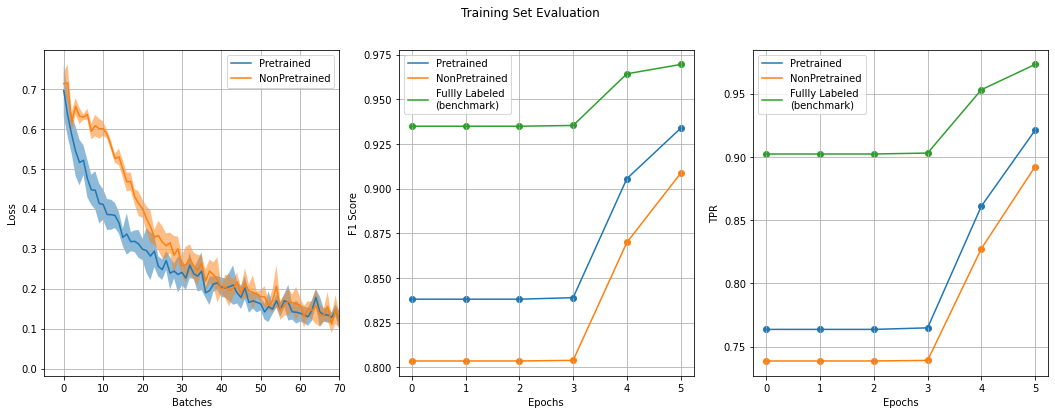

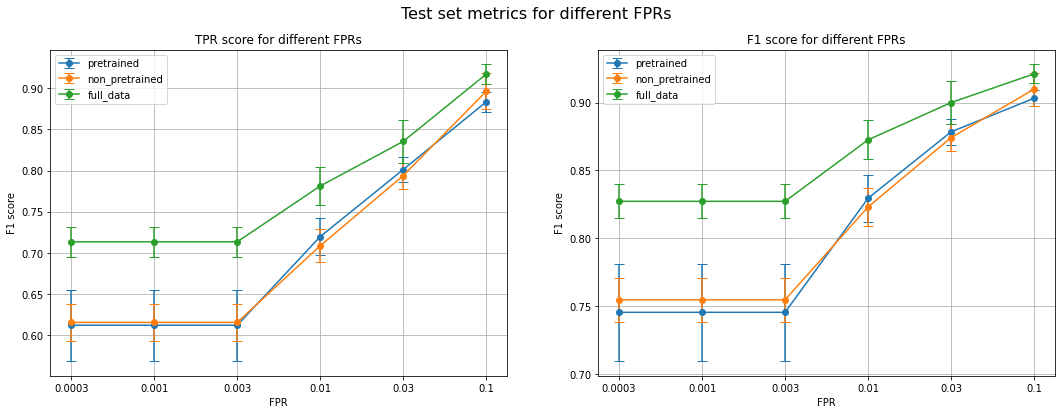

In [168]:
runFolder = r"MaskedLanguageModeling\unlabeledDataSize_0.8_preTrain_10_downStream_3_nSplits_5_1672232495"
getMainStats(runFolder)

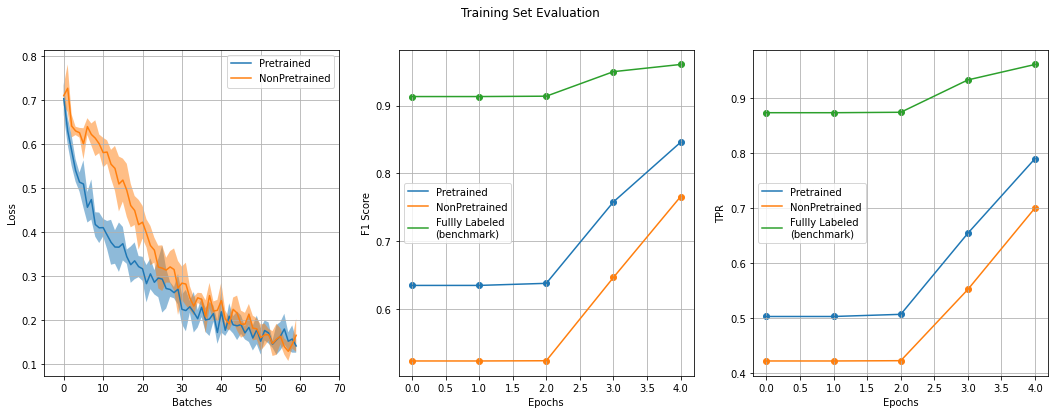

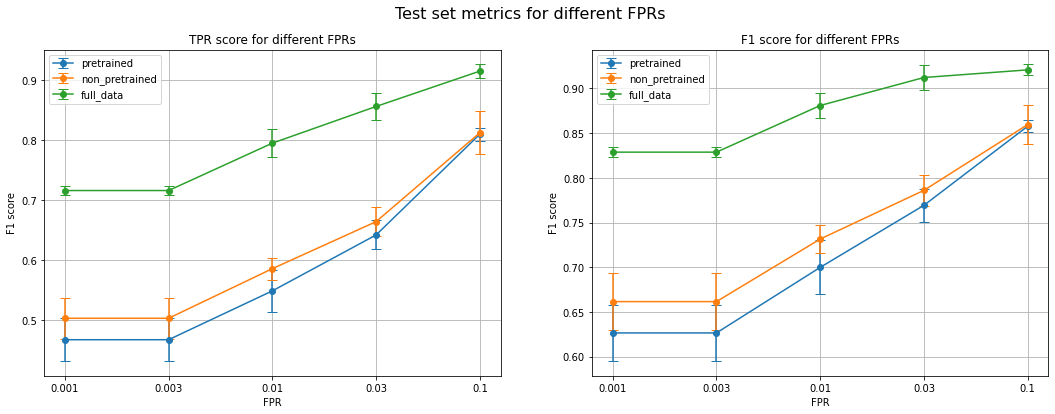

In [169]:
runFolder = r"MaskedLanguageModeling\unlabeledDataSize_0.9_preTrain_5_downStream_2_nSplits_5_1672239000"
getMainStats(runFolder)

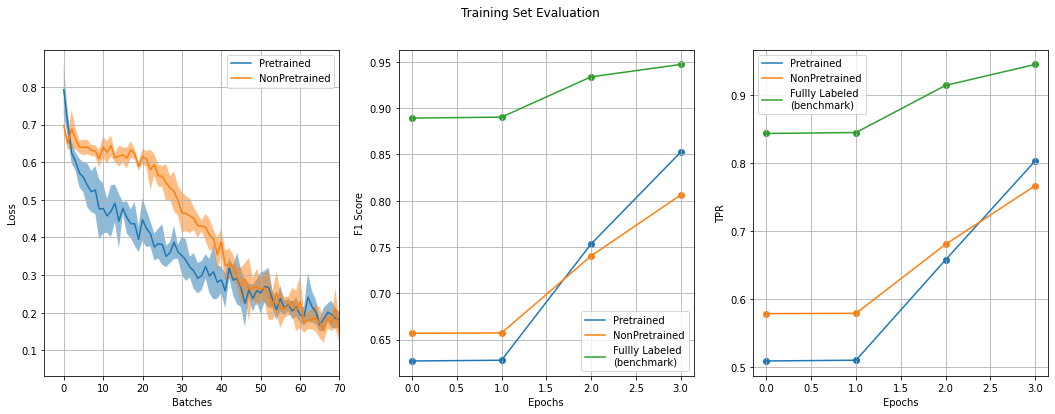

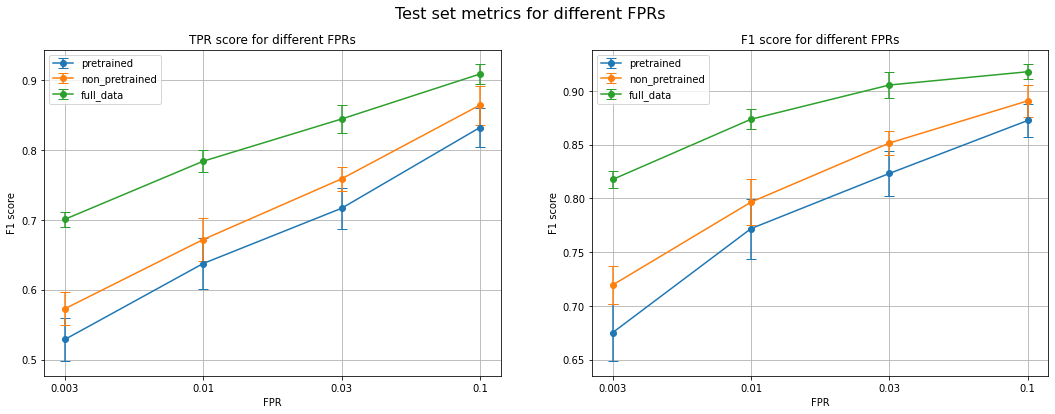

In [170]:
runFolder = r"MaskedLanguageModeling\deeperCnn_unlabeledDataSize_0.8_preTrain_5_downStream_2_nSplits_5_1672252066"
getMainStats(runFolder)